# Práctico

El trabajo práctico de la materia consiste en el análisis de un conjunto de datos extraído de Twitter. La idea es emplear los conceptos de grafos vistos en clase sobre un caso real de actualidad.

## Dataset

El dataset consiste en un conjunto de hilos de tweets, con un total de ~150000 tweets, extraídos entre Enero y Marzo de 2021. La temática de los mismos está referida a la vacunación contra el covid-19 en Argentina.

Pueden descargar el dataset del siguiente [link](https://drive.google.com/file/d/1X_qKsE8muAnom2tDX4sLlmBAO0Ikfe_G/view?usp=sharing).

### Campos

- **created_at:** Fecha del tweet
- **id_str:** ID del tweet
- **full_text:** Contenido del tweet
- **in_reply_to_status_id:** ID del tweet inmediatamente anterior en el hilo
- **in_reply_to_user_id:** Autor del tweet inmediatamente anterior en el hilo
- **user.id:** Autor del tweet
- **user_retweeters:** Lista de ID de usuarios que retweetearon el tweet
- **sentiment:** Etiquetado manual que indica el sentimiento o intención del tweet con respecto al tweet anterior en el hilo

Ejemplo

<img src="./figuras/twitter-thread.jpg" width="500"/>

## Configuración inicial

In [1]:
import pandas as pd
import os
import networkx as nx

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

In [2]:
## Descargar el csv con los datos en este directorio
DATA_DIR = Path(os.path.join(os.getcwd(), "data", "twitter"))
INPUT_FILE = DATA_DIR / "vacunas.csv"

## Creamos el directorio en caso de que no exista
DATA_DIR.mkdir(parents=True, exist_ok=True)

### Cargamos el dataset

In [3]:
dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}

df = pd.read_csv(INPUT_FILE, dtype=dtypes).dropna(subset=['user_retweeters'])

df["user_retweeters"] = df["user_retweeters"].apply(lambda x: [str(elem) for elem in eval(x)])

print('Shape:', df.shape)

df.head()

Shape: (155123, 8)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN


### Observamos algunos ejemplos

In [4]:
idx = 0
print('Texto:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Texto: Seguimos esperando el comunicado de @norabar repudiando la situación respecto del gobierno y el tema vacunas. Seamos pacientes que con esto de la pandemia anda con mucho "laburo".
Retweets: 9


In [5]:
idx = 376
print('Text:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Text: Todo lo que hay que entender sobre la decisión –o no– de poner más vacunas en más brazos (por ejemplo, usar las 1º dosis en muchos y si es necesario retrasar la 2º) está en esta excelente nota de Nora Bär. https://t.co/A0I03DyxgO
Retweets: 48


### Calculamos la cantidad de hilos

In [6]:
roots = df[df['in_reply_to_user_id'].isna()]
roots.shape

(3174, 8)

## Actividades

### Primera parte

#### **1. Construcción del grafo** 

Construir el **grafo de retweets**, definido de la siguiente manera:

- Tipo de grafo: Dirigido
- Nodos: ID de los usuarios
- Enlaces: (Usuario A) ---> (Usuario B) si B retweeteó algún tweet de A

Con estos datos, el grafo debería tener alrededor de 40000 nodos y 90000 enlaces.

Considerar la versión no dirigida del grafo y estudiar su conectividad. Si existe una única "componente gigante", realizar el resto de las actividades sobre ella, en lugar de sobre el grafo completo.

Calcular las siguientes métricas globales del grafo:

- Grado medio
- Asortatividad
- Transitividad
- Coeficiente de clustering de Watts-Strogatz

**Opcional:** Comparar las métricas calculadas anteriormente con las de un grafo aleatorio con la misma distribución de grado. Pueden utilizar para ello este [método](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration#networkx.generators.degree_seq.configuration_model). Con esto en mente, comentar si los valores obtenidos anteriormente difieren significativamente del caso aleatorio.


#### **2. Centralidad**

Calcular 5 métricas de centralidad de nodos. Graficar la distribución de cada una de ellas ¿Existe alguna correlación entre las distintas centralidades?

Hacer un ranking con los 10 nodos más centrales para cada métrica. ¿Hay coincidencia entre los rankings?. ¿Qué características tienen los usuarios más centrales y sus respectivos tweets?

**Opcional:** Determinar si existe alguna correlación entre la centralidad de un nodo y su actividad en red social. Es decir, evaluar si los usuarios que más escriben son los más centrales o no.

**Observación:** El cálculo de centralidad puede ser costoso, por lo que es recomendable utilizar alguna librería más eficiente que `networkx`. La más simple de usar es `igraph` (ver [documentación](https://igraph.readthedocs.io/en/stable/)). En particular, resulta práctico utilizar el método `igraph.Graph().from_networkx()`, para convertir fácilmente un grafo de `networkx` a `igraph`.

#### **3. Comunidades**

Utilizar el algoritmo de Louvain con el parámetro "resolución" igual a 1. Caracterizar las comunidades halladas (cantidad, distribución de tamaños). Utilizar la modularidad y otras dos métricas a elección para evaluar la calidad de la partición encontrada. 

Variar el parámetro "resolución" y observar cómo cambia la distribución de comunidades encontradas. ¿Existe algún valor para el cual se identifiquen dos grandes comunidades?

Elegir otro algoritmo de detección de comunidades y comparar los resultados con los obtenidos anteriormente.

**Opcional:** Correr el algoritmo de Louvain con distintas semillas aleatorias. Utilizar alguna métrica de comparación externa entre las particiones obtenidas para determinar en qué medida depende el algoritmo de la condición inicial.

### Resolución

#### **1. Construcción del grafo** 

Construir el **grafo de retweets**, definido de la siguiente manera:

- Tipo de grafo: Dirigido
- Nodos: ID de los usuarios
- Enlaces: (Usuario A) ---> (Usuario B) si B retweeteó algún tweet de A

Con estos datos, el grafo debería tener alrededor de 40000 nodos y 90000 enlaces.

Considerar la versión no dirigida del grafo y estudiar su conectividad. Si existe una única "componente gigante", realizar el resto de las actividades sobre ella, en lugar de sobre el grafo completo.

Calcular las siguientes métricas globales del grafo:

- Grado medio
- Asortatividad
- Transitividad
- Coeficiente de clustering de Watts-Strogatz

**Opcional:** Comparar las métricas calculadas anteriormente con las de un grafo aleatorio con la misma distribución de grado. Pueden utilizar para ello este [método](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration#networkx.generators.degree_seq.configuration_model). Con esto en mente, comentar si los valores obtenidos anteriormente difieren significativamente del caso aleatorio.

In [7]:
# Se duplican tantas filas para que la columna user_retweeters tenga un id por fila.
new_df = df.copy()
new_df = new_df.assign(user_retweet_id=df["user_retweeters"]).explode("user_retweet_id").reset_index(drop=True)
new_df = new_df.drop_duplicates(["user.id", "user_retweet_id"], keep="last").reset_index(drop=True)
new_df = new_df[new_df["user_retweet_id"].notna()].reset_index(drop=True)

new_df

,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment,user_retweet_id
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN,2258074658
1,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN,159909978
2,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN,105301854
3,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN,290671142
4,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN,208721168
...,...,...,...,...,...,...,...,...,...
93687,Tue Jan 12 13:02:18 +0000 2021,1348978612632956929,@Argentano4 @OEdurne @norabar @dianamaffia #re...,1348972409420984320,1345042868524744708,437640516,[1314707677096927234],NaN,1314707677096927234
93688,Tue Jan 12 12:52:46 +0000 2021,1348976211112898560,@miseriadigna22 @Ing_Torta @peredaarias @norab...,1348974971490619395,4819951305,58065646,[353854993],NaN,353854993
93689,Wed Jan 13 00:04:36 +0000 2021,1349145284614512643,@DeChouza @norabar Y así fue como Nora fue per...,1349144383799652353,1266212657272696832,79840600,"[1363288094, 2258074658]",NaN,1363288094
93690,Wed Jan 13 00:04:36 +0000 2021,1349145284614512643,@DeChouza @norabar Y así fue como Nora fue per...,1349144383799652353,1266212657272696832,79840600,"[1363288094, 2258074658]",NaN,2258074658


In [8]:
# Se crea grafo dirigido
dG = nx.DiGraph()

dG.add_nodes_from(new_df["user.id"].unique())

# agregar aristas al grafo desde las columnas 'source' y 'target'
dG.add_edges_from(zip(new_df["user.id"], new_df["user_retweet_id"]))

# imprimir información del grafo
print(nx.info(dG))

DiGraph with 39800 nodes and 93692 edges


C:\Users\pablonicolasr\AppData\Local\Temp\ipykernel_24012\1974490645.py:10: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(dG))


In [9]:
print(f"Cantidad de nodos: {dG.number_of_nodes()}")
print(f"Cantidad de links: {dG.number_of_edges()}")

Cantidad de nodos: 39800
Cantidad de links: 93692


In [10]:
G = nx.Graph()

# agregar nodos al grafo desde la columna 'source'
G.add_nodes_from(new_df["user.id"].unique())

# agregar aristas al grafo desde las columnas 'source' y 'target'
G.add_edges_from(zip(new_df["user.id"], new_df["user_retweet_id"]))

In [11]:
print(f"Cantidad de nodos: {G.number_of_nodes()}")
print(f"Cantidad de links: {G.number_of_edges()}")

Cantidad de nodos: 39800
Cantidad de links: 93404


In [12]:
# Calcula las componentes conectadas
componentes = list(nx.connected_components(G))

In [13]:
# Se observa la amplitud de cada componente y se imprime aquellas que por lo menos tienen más de la mitad de los nodos del grafo
for i, value in enumerate(componentes):
    if len(value) > (G.number_of_nodes() / 2):
        print(i, len(value))

0 38998


In [14]:
mayor_componente = max(componentes, key=len)

# Crea un subgrafo a partir de la componente con el mayor número de nodos
subG = G.subgraph(mayor_componente)


# Imprime la información del subgrafo
print("Número de nodos del subgrafo: ", subG.number_of_nodes())
print("Número de aristas del subgrafo: ", subG.number_of_edges())

Número de nodos del subgrafo:  38998
Número de aristas del subgrafo:  92830


In [15]:
# Grado medio del grafo

# Calcula la conectividad media de cada grado
conectividad_media = nx.average_degree_connectivity(subG)

print(conectividad_media)

{9: 1140.7980989839398, 8207: 7.495187035457536, 8: 1126.363299086758, 28: 374.0631868131868, 5362: 6.921671018276762, 13: 850.6448959845186, 7: 1282.7922998986828, 5: 1627.6942528735633, 1: 3221.9344762901887, 19: 619.7239766081872, 12: 824.2035256410256, 6: 1531.9019485903814, 4: 1870.688940809969, 278: 53.95323741007194, 10: 1026.9625899280575, 24: 518.700925925926, 46: 199.30769230769232, 112: 20.4375, 92: 187.4963768115942, 15: 694.131623931624, 5553: 6.8679992796686475, 18: 667.1095679012345, 25: 472.25272727272727, 23: 498.8636897767333, 11: 920.1929046563193, 21: 528.1119929453263, 49: 172.91476590636253, 116: 111.91810344827586, 14: 774.2056122448979, 3: 2112.23696857671, 2: 2600.102735042735, 51: 183.1870286576169, 43: 196.1031976744186, 20: 549.2639534883721, 3175: 9.179527559055119, 1630: 14.926993865030674, 3849: 9.97090153286568, 32: 381.3578125, 60: 280.5805555555556, 16: 652.5823598130842, 3136: 10.546875, 41: 245.9043151969981, 17: 619.5762175838078, 206: 76.2864077669

In [16]:
print(type(conectividad_media))

<class 'dict'>


In [17]:
# Calcula el grado medio del grafo
grado_medio = sum(d * n for d, n in conectividad_media.items()) / subG.number_of_nodes()

# Imprime el grado medio del grafo
print("El grado medio del grafo es:", grado_medio)

El grado medio del grafo es: 62.97717408104595


In [18]:
# Assortativity
print(f"Asortatividad: {nx.degree_assortativity_coefficient(subG)}")

Asortatividad: -0.22289852028043194


In [19]:
# Transitividad
print(f"Transitividad: {nx.transitivity(subG)}")

Transitividad: 0.0016123660217598865


In [20]:
# Calcula el coeficiente de clustering de Watts-Strogatz del grafo
coeficiente_clustering = nx.average_clustering(subG)

# Imprime el coeficiente de clustering de Watts-Strogatz del grafo
print(f"El coeficiente de clustering de Watts-Strogatz del grafo es: {coeficiente_clustering}")

El coeficiente de clustering de Watts-Strogatz del grafo es: 0.10189800595168706


# OPCIONAL

Se crea un subgrafo aleatorio con el mismo gradio medio que el anterior

In [21]:
# Establece el número de nodos y el grado medio deseado
n = 30000
k = 63


# Calcula la probabilidad de reorganizar las conexiones
p = k / (n - 1)


# Crea un grafo aleatorio con el grado medio deseado
randomG = nx.watts_strogatz_graph(int(n), int(k), int(p))

# Imprime el número de nodos, el número de aristas y el grado medio del grafo aleatorio
print("El grafo aleatorio tiene", n, "nodos y", randomG.number_of_edges(), "aristas.")
print("El grado medio del grafo aleatorio es:", sum(dict(randomG.degree()).values()) / n)

El grafo aleatorio tiene 30000 nodos y 930000 aristas.
El grado medio del grafo aleatorio es: 62.0


In [22]:
# Transitividad
print(f"Transitividad: {nx.transitivity(randomG)}")

Transitividad: 0.7377049180327869


In [23]:
# Assortativity
print(f"Asortatividad: {nx.degree_assortativity_coefficient(randomG)}")

Asortatividad: nan


C:\Users\pablonicolasr\anaconda3\envs\grafos\lib\site-packages\networkx\algorithms\assortativity\correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [24]:
# Calcula el coeficiente de clustering de Watts-Strogatz del grafo
coeficiente_clustering = nx.average_clustering(randomG)

# Imprime el coeficiente de clustering de Watts-Strogatz del grafo
print(f"El coeficiente de clustering de Watts-Strogatz del grafo es: {coeficiente_clustering}")

El coeficiente de clustering de Watts-Strogatz del grafo es: 0.7377049180325069


# Conclusiones

Los resultados del grafo aleatorio si difieren significativamente de los obtenidos en el subgrafo de mayor componente.

# **2. Centralidad**

Calcular 5 métricas de centralidad de nodos. Graficar la distribución de cada una de ellas ¿Existe alguna correlación entre las distintas centralidades?

Hacer un ranking con los 10 nodos más centrales para cada métrica. ¿Hay coincidencia entre los rankings?. ¿Qué características tienen los usuarios más centrales y sus respectivos tweets?

**Opcional:** Determinar si existe alguna correlación entre la centralidad de un nodo y su actividad en red social. Es decir, evaluar si los usuarios que más escriben son los más centrales o no.

**Observación:** El cálculo de centralidad puede ser costoso, por lo que es recomendable utilizar alguna librería más eficiente que `networkx`. La más simple de usar es `igraph` (ver [documentación](https://igraph.readthedocs.io/en/stable/)). En particular, resulta práctico utilizar el método `igraph.Graph().from_networkx()`, para convertir fácilmente un grafo de `networkx` a `igraph`.

# Se crea matriz de adyacencia

In [25]:
adj_matrix = nx.adjacency_matrix(subG)

C:\Users\pablonicolasr\AppData\Local\Temp\ipykernel_24012\1096022811.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(subG)


In [26]:
import igraph as ig
import numpy as np

In [27]:
print(adj_matrix)

  (0, 1119)	1
  (0, 1377)	1
  (0, 4314)	1
  (0, 4599)	1
  (0, 8122)	1
  (0, 8123)	1
  (0, 8124)	1
  (0, 8125)	1
  (0, 8126)	1
  (1, 2)	1
  (1, 3)	1
  (1, 30)	1
  (1, 31)	1
  (1, 35)	1
  (1, 36)	1
  (1, 37)	1
  (1, 38)	1
  (1, 39)	1
  (1, 40)	1
  (1, 41)	1
  (1, 42)	1
  (1, 46)	1
  (1, 47)	1
  (1, 48)	1
  (1, 49)	1
  :	:
  (38974, 105)	1
  (38975, 105)	1
  (38976, 32)	1
  (38977, 32)	1
  (38978, 32)	1
  (38979, 32)	1
  (38980, 32)	1
  (38981, 32)	1
  (38982, 32)	1
  (38983, 32)	1
  (38984, 32)	1
  (38985, 32)	1
  (38986, 32)	1
  (38987, 32)	1
  (38988, 32)	1
  (38989, 32)	1
  (38990, 32)	1
  (38991, 32)	1
  (38992, 32)	1
  (38993, 32)	1
  (38994, 32)	1
  (38995, 466)	1
  (38995, 8112)	1
  (38996, 8117)	1
  (38997, 8118)	1


In [28]:
subG_igraph = ig.Graph.Adjacency(adj_matrix, mode="UNDIRECTED")

# Centralidad de intermediación (betweenness centrality): 

Mide la cantidad de veces que un vértice aparece en el camino más corto entre dos vértices.

In [29]:
betweenness = subG_igraph.betweenness() # devuelve una lista con la intermediación de cada vértice

# Centralidad de grado: 

Mide la importancia de un vértice en función del número de aristas que lo conectan con otros vértices.

In [30]:
degree = subG_igraph.degree() # devuelve una lista con los grados de cada vértice

# Centralidad de cercanía (closeness centrality): 

Mide la distancia promedio entre un vértice y todos los demás vértices del grafo.

In [31]:
closeness = subG_igraph.closeness() # devuelve una lista con la cercanía de cada vértice

# Centralidad de autovector (eigenvector centrality): 

Mide la importancia de un vértice en función de la importancia de sus vecinos.

In [32]:
eigenvector = subG_igraph.eigenvector_centrality() # devuelve una lista con la centralidad de autovector de cada vértice

# Centralidad PageRank (PageRank centrality): 

Mide la importancia de un nodo en función de la importancia de sus vecinos y de la cantidad de vecinos que tiene..

In [33]:
katz_centrality = subG_igraph.pagerank()

In [34]:
print(betweenness)

[78111.6408520984, 270336415.49197906, 19680.202092674248, 60809.68660284044, 125953303.87853128, 46479.84055241848, 136.0549437371776, 29444.56801463447, 4534.628462054578, 45534.460094440205, 39034.82236943538, 0.0, 115340.23316028978, 0.0, 20310.042770624466, 127456.43521610418, 1291.1868908167528, 7485.430947315229, 0.0, 1417074.786079675, 42256.6689864673, 0.0, 281166.4622970765, 380100.4368470471, 6023.090582997739, 28234.02685219636, 11598.279967867322, 405006.5347791326, 142380.1310432912, 2732.9820172395202, 3939145.439811485, 78353.07446586006, 178518084.46291906, 14742.690627044743, 22455.906650205852, 147755.60012925422, 10328.051263982503, 12279.494871878464, 28903.825746612983, 179184.66945692743, 33477.23254698256, 318091.1986031117, 10843.302101427393, 62.81682585611067, 8.061285551637152, 106.70857904609319, 90911.08187540626, 1047.5327301325378, 94560.88999171338, 12589.144146102304, 82231.1550221202, 75425861.55113961, 27024092.232040115, 301.6396219065189, 91794534.

In [35]:
print(degree)

[9, 8207, 8, 28, 5362, 13, 7, 13, 7, 13, 5, 1, 19, 1, 12, 6, 4, 12, 1, 278, 10, 1, 24, 46, 6, 8, 8, 112, 24, 4, 92, 15, 5553, 18, 18, 25, 23, 11, 21, 49, 15, 116, 14, 3, 2, 3, 51, 6, 43, 21, 20, 3175, 1630, 8, 3849, 32, 8, 8, 60, 15, 2, 21, 1, 16, 6, 2, 4, 3136, 41, 3, 11, 17, 15, 206, 15, 14, 33, 9, 7, 80, 77, 9, 38, 14, 57, 12, 5, 7, 1, 154, 26, 190, 33, 2657, 10, 28, 6, 126, 3, 51, 1, 8, 7, 133, 29, 3834, 12, 2, 48, 2, 1, 1, 38, 1, 6, 2, 3, 10, 2, 3, 13, 4, 9, 14, 28, 1, 12, 384, 1, 2, 5, 67, 5, 15, 1, 41, 41, 38, 2, 8, 8, 3, 29, 1, 8, 50, 1, 16, 2, 11, 47, 4, 26, 61, 68, 21, 3, 31, 3, 5, 2, 2, 36, 17, 8, 181, 20, 12, 5, 17, 13, 18, 34, 2, 94, 21, 40, 81, 3, 1, 4, 6, 11, 64, 12, 8, 37, 4, 14, 315, 74, 10, 15, 17, 7, 22, 18, 15, 11, 26, 9, 365, 1, 72, 73, 10, 77, 7, 5, 7, 68, 36, 29, 12, 44, 18, 29, 1, 47, 5, 11, 4, 1, 2, 8, 5, 17, 8, 22, 1, 277, 16, 1, 2, 9, 2, 1, 23, 51, 2, 1, 7, 36, 40, 27, 7, 12, 6, 20, 1, 44, 4, 1, 3, 10, 87, 3, 4, 142, 3, 13, 8, 6, 1, 1, 2, 86, 35, 1, 1, 187, 5

In [36]:
print(closeness)

[0.2448975746995064, 0.39222924042484714, 0.3042552195487314, 0.28520547344093966, 0.3712903809351525, 0.2970634164920967, 0.25802929850331496, 0.32655607566635125, 0.27846447162657184, 0.3236319275008714, 0.28529936790354676, 0.23729030138186596, 0.3295279782325802, 0.24932230263662636, 0.28391187862197503, 0.32067264205246276, 0.2871163205053636, 0.31536427375724785, 0.22198251326305243, 0.3364739989128465, 0.3260482421303457, 0.24932230263662636, 0.3517394402402836, 0.3293303944668237, 0.2710440167643195, 0.3012956710525299, 0.2811445626784324, 0.308493722856397, 0.29747129943933787, 0.28600240553860595, 0.34775591007588796, 0.28521590310689837, 0.3981154419421361, 0.2843714906587717, 0.2931003382187148, 0.30526983232351695, 0.31040164286737665, 0.3135411976587123, 0.29710641799232035, 0.3017176015473888, 0.30540371211527917, 0.32105016177233325, 0.3152342613250558, 0.23941284088258047, 0.23486509274873524, 0.2477069464911835, 0.31190363835590146, 0.30431220151699595, 0.297657484371

In [37]:
print(eigenvector)

[0.000748395696502655, 0.7383386102245293, 0.010699299470293083, 0.010561277688182212, 0.9723623652465162, 0.0031491161110989902, 0.0015193307202770307, 0.03423147842232103, 0.006072696568326056, 0.02957462982293155, 0.010957892275754295, 0.00026931227859744124, 0.036453577852599006, 0.00046757645382676516, 0.012180246124193453, 0.025248252367180254, 0.017273316901512348, 0.02101538731777687, 8.481676982299369e-05, 0.09111185839352434, 0.026659559426206528, 0.00046757645382676565, 0.038531563755234775, 0.03660936198462886, 0.006187791802143899, 0.02239440569078604, 0.0014480799255326905, 0.031073284439876454, 0.009455438039400112, 0.00808488423127328, 0.027936111350476314, 0.009069862559287201, 1.0, 0.0032740824258448292, 0.004081335551047821, 0.012749562011030781, 0.01115710048498419, 0.011818773469258645, 0.01038240944011192, 0.013230981775880259, 0.012035654410162562, 0.024833253685775634, 0.012658280990696737, 0.0004337456307023366, 0.0002933107462812417, 0.0009043161622160817, 0.0

In [38]:
print(katz_centrality)

[3.899729636265475e-05, 0.04155926771360683, 3.4950583976986244e-05, 9.40854756721817e-05, 0.03150033742485089, 6.644748023874091e-05, 3.4882882986752796e-05, 6.00492959612652e-05, 3.593334227329553e-05, 6.243926699418702e-05, 2.8846979769347e-05, 9.946682262205356e-06, 9.168981869585545e-05, 7.723255550939627e-06, 5.426871627831747e-05, 4.0422740292992137e-05, 2.3110717306825442e-05, 5.3881666257345574e-05, 7.499046927870825e-06, 0.0012078798849524733, 4.794462905895545e-05, 7.723255550939627e-06, 0.00010875129215464636, 0.00020324691939218537, 3.1144567350833216e-05, 4.201271377712917e-05, 3.794535718434179e-05, 0.0004927888350229965, 0.00011232857601315686, 2.304496173491457e-05, 0.00031044172190444383, 6.005892920968888e-05, 0.0338693457522262, 5.705643748269627e-05, 5.9950729593606566e-05, 9.427959580488141e-05, 7.245279493646735e-05, 3.814917895088658e-05, 7.076164138231028e-05, 0.00016723533192371535, 5.4277934766534274e-05, 0.0003690393275244662, 4.7327075808983964e-05, 1.32217

# Se calcula la correlación entre las medidas de centralidad calculadas

Para calcular si hay correlación entre las métricas de centralidad en un grafo, se puede utilizar la función pearsonr de la librería scipy.stats.

El coeficiente de correlación de Pearson oscila entre -1 y 1, donde -1 indica una correlación negativa perfecta, 0 indica ausencia de correlación y 1 indica una correlación positiva perfecta. El valor p indica la significancia estadística de la correlación (es decir, si la correlación es estadísticamente significativa o no). Si el valor p es menor que un nivel de significancia predefinido (por ejemplo, 0.05), se puede concluir que la correlación es estadísticamente significativa.

In [39]:
from scipy.stats import pearsonr
from itertools import combinations

In [40]:
def all_combinations(lst):
    
    all_combinations = []
    combos = combinations(lst, 2)
    all_combinations.extend(combos)

    
    return all_combinations

In [41]:
dict_metrics = {
    "betweenness": betweenness, 
    "degree": degree, 
    "closeness": closeness, 
    "eigenvector": eigenvector, 
    "katz_centrality": katz_centrality,
}

In [42]:
list_metrics = ["betweenness", "degree", "closeness", "eigenvector", "katz_centrality"]

In [43]:
all_combs = all_combinations(list_metrics)

In [44]:
print(all_combs)

[('betweenness', 'degree'), ('betweenness', 'closeness'), ('betweenness', 'eigenvector'), ('betweenness', 'katz_centrality'), ('degree', 'closeness'), ('degree', 'eigenvector'), ('degree', 'katz_centrality'), ('closeness', 'eigenvector'), ('closeness', 'katz_centrality'), ('eigenvector', 'katz_centrality')]


In [45]:
for comb in all_combs:
    # Calcular el coeficiente de correlación de Pearson
    corr, p_value = pearsonr(dict_metrics[comb[0]], dict_metrics[comb[1]])
    print("------------------------------------------------------------------------")
    print(f"Las medidas de correlación entre las medidas {comb[0]} y {comb[1]} SON:")    
    print("Coeficiente de correlación de Pearson entre:", corr)
    print("Valor p:", p_value)
    if corr > 0.75:
        print(f"LA CORRELACIÓN ENTRE {comb[0]} y {comb[1]} ES FUERTEMENTE POSITIVA")
    elif corr <= 0.75 and corr > 0.5:
        print(f"LA CORRELACIÓN ENTRE {comb[0]} y {comb[1]} ES POSITIVA")
    elif corr <= 0.5 and corr > 0.25:
        print(f"LA CORRELACIÓN ENTRE {comb[0]} y {comb[1]} ES DEBILMENTE POSITIVA")
    elif corr <= 0.25  and corr >= -0.25:
        print(f"LA CORRELACIÓN ENTRE {comb[0]} y {comb[1]} NO TIENE CORRELACIÓN")
    elif corr < -0.25  and corr >= -0.5:
        print(f"LA CORRELACIÓN ENTRE {comb[0]} y {comb[1]} ES DEBILMENTE NEGATIVA")
    elif corr < -0.5   and corr >= -0.75:
        print(f"LA CORRELACIÓN ENTRE {comb[0]} y {comb[1]} ES NEGATIVA")
    else:
        print(f"LA CORRELACIÓN ENTRE {comb[0]} y {comb[1]} ES FUERTEMENTE NEGATIVA") 
    
    print("------------------------------------------------------------------------")

------------------------------------------------------------------------
Las medidas de correlación entre las medidas betweenness y degree SON:
Coeficiente de correlación de Pearson entre: 0.9823546627957946
Valor p: 0.0
LA CORRELACIÓN ENTRE betweenness y degree ES FUERTEMENTE POSITIVA
------------------------------------------------------------------------
------------------------------------------------------------------------
Las medidas de correlación entre las medidas betweenness y closeness SON:
Coeficiente de correlación de Pearson entre: 0.06982505000685343
Valor p: 2.3646240671625968e-43
LA CORRELACIÓN ENTRE betweenness y closeness NO TIENE CORRELACIÓN
------------------------------------------------------------------------
------------------------------------------------------------------------
Las medidas de correlación entre las medidas betweenness y eigenvector SON:
Coeficiente de correlación de Pearson entre: 0.7347194725365885
Valor p: 0.0
LA CORRELACIÓN ENTRE betweennes

# OBSERVACIONES

En general, se puede observar que existe una correlación positiva entre las medidas de centralidad.

Lo que si se puede ver es que la medida closeness (Mide la distancia promedio entre un vértice y todos los demás vértices del grafo) no tiene correlación con las demás medidas salvo con eigenvector (Mide la importancia de un vértice en función de la importancia de sus vecinos), es decir que la distancia promedio está relacionada con la importancia de los vecinos de un nodo dado.

# Hacer un ranking con los 10 nodos más centrales para cada métrica. ¿Hay coincidencia entre los rankings?. ¿Qué características tienen los usuarios más centrales y sus respectivos tweets?

In [46]:
# Ordenar los nodos por su valor de centralidad
sorted_nodes = sorted(list(zip(betweenness, range(subG_igraph.vcount()))), reverse=True)

# Seleccionar los primeros 10 nodos más centrales
top_nodes_betweenness = [x[1] for x in sorted_nodes[:10]]

print("Los 10 nodos más centrales para la centralidad 'betweenness', son: ", top_nodes_betweenness)

Los 10 nodos más centrales para la centralidad 'betweenness', son:  [1, 32, 4, 105, 67, 54, 51, 93, 52, 385]


In [47]:
# Ordenar los nodos por su valor de centralidad
sorted_nodes = sorted(list(zip(degree, range(subG_igraph.vcount()))), reverse=True)

# Seleccionar los primeros 10 nodos más centrales
top_nodes_degree = [x[1] for x in sorted_nodes[:10]]

print("Los 10 nodos más centrales para la centralidad 'degree', son: ", top_nodes_degree)

Los 10 nodos más centrales para la centralidad 'degree', son:  [1, 32, 4, 54, 105, 51, 67, 93, 52, 323]


In [48]:
# Ordenar los nodos por su valor de centralidad
sorted_nodes = sorted(list(zip(closeness, range(subG_igraph.vcount()))), reverse=True)

# Seleccionar los primeros 10 nodos más centrales
top_nodes_closeness = [x[1] for x in sorted_nodes[:10]]

print("Los 10 nodos más centrales para la centralidad 'closeness', son: ", top_nodes_closeness)

Los 10 nodos más centrales para la centralidad 'closeness', son:  [32, 420, 17069, 12739, 14676, 1, 385, 21915, 8486, 54]


In [49]:
# Ordenar los nodos por su valor de centralidad
sorted_nodes = sorted(list(zip(eigenvector, range(subG_igraph.vcount()))), reverse=True)

# Seleccionar los primeros 10 nodos más centrales
top_nodes_eigenvector = [x[1] for x in sorted_nodes[:10]]

print("Los 10 nodos más centrales para la centralidad 'eigenvector', son: ", top_nodes_eigenvector)

Los 10 nodos más centrales para la centralidad 'eigenvector', son:  [32, 4, 1, 54, 51, 105, 52, 93, 67, 19]


In [50]:
# Ordenar los nodos por su valor de centralidad
sorted_nodes = sorted(list(zip(katz_centrality, range(subG_igraph.vcount()))), reverse=True)

# Seleccionar los primeros 10 nodos más centrales
top_nodes_katz_centrality = [x[1] for x in sorted_nodes[:10]]

print("Los 10 nodos más centrales para la centralidad 'katz_centrality', son: ", top_nodes_katz_centrality)

Los 10 nodos más centrales para la centralidad 'katz_centrality', son:  [1, 32, 4, 105, 54, 51, 93, 67, 52, 323]


In [51]:
def commonList(lst1, lst2):    
    
    
    return [x for x in lst1 if x in lst2]   
    

def commonElements(*args):
    
    commonE = []
    
    for i in range(0, len(args) - 1):
        
        print(i)
        
        if i == 0:
            
            aux = commonList(args[i], args[i + 1])
            
            if len(aux) == 0:
                
                return "NO HAY ELEMENTOS EN COMUN"
        
            commonE.extend(aux)
        
        else:
            
            commonE = commonList(commonE, args[i + 1]) 
    
    return commonE

In [52]:
lista_comun = commonElements(top_nodes_betweenness, top_nodes_degree, top_nodes_closeness, top_nodes_eigenvector, top_nodes_katz_centrality)

0
1
2
3


In [53]:
print(lista_comun)

[1, 32, 54]


# Observaciones

Existen 3 elementos que se repiten en los 5 ranking, aunque por lo general son los mismos, el ranking top_nodes_closeness es el que difiere significativamente del resto. Esta comparación explican los resultados de correlación en el inciso anterior, ya que la misma medida tiene poca correlación con las demás.

In [54]:
# Obtener información de nodos en grafo original
nodes_data = new_df.to_dict(orient="records")

# Obtener información de nodos en grafo de igraph
igraph_data = [nodes_data[i] for i in lista_comun]

In [55]:
igraph_data

[{'created_at': 'Sat Feb 20 03:09:10 +0000 2021',
  'id_str': '1362962469749153792',
  'full_text': 'Seguimos esperando el comunicado de @norabar repudiando la situación respecto del gobierno y el tema vacunas. Seamos pacientes que con esto de la pandemia anda con mucho "laburo".',
  'in_reply_to_status_id': nan,
  'in_reply_to_user_id': nan,
  'user.id': '2737379453',
  'user_retweeters': ['2258074658',
   '159909978',
   '105301854',
   '290671142',
   '208721168',
   '706109159708729344',
   '742492143885930496',
   '473194490',
   '155395122'],
  'sentiment': nan,
  'user_retweet_id': '159909978'},
 {'created_at': 'Tue Feb 23 04:34:33 +0000 2021',
  'id_str': '1364071123344896000',
  'full_text': '@spitta1969 Las penas son de nosotros, las vacunas son ajenas.',
  'in_reply_to_status_id': '1364000806740111363',
  'in_reply_to_user_id': '252168075',
  'user.id': '2915779377',
  'user_retweeters': ['920281298735976449',
   '1928320513',
   '846698894742474754',
   '1192415849400938496

# Observaciones

Seguimos esperando el comunicado de @norabar repudiando la situación respecto del gobierno y el tema vacunas. Seamos pacientes que con esto de la pandemia anda con mucho "laburo".

Las penas son de nosotros, las vacunas son ajenas.

Estos twitters tiene la coincidencia que de aplicar un algoritmo de análisis de sentimiento, este algoritmo diría que se realizó UNA MALA gestión en el tema de las vacunas de parte del gobierno

# **3. Comunidades**

Utilizar el algoritmo de Louvain con el parámetro "resolución" igual a 1. Caracterizar las comunidades halladas (cantidad, distribución de tamaños). Utilizar la modularidad y otras dos métricas a elección para evaluar la calidad de la partición encontrada. 

Variar el parámetro "resolución" y observar cómo cambia la distribución de comunidades encontradas. ¿Existe algún valor para el cual se identifiquen dos grandes comunidades?

Elegir otro algoritmo de detección de comunidades y comparar los resultados con los obtenidos anteriormente.

In [56]:
# Ejecutar algoritmo de Louvain
louvain_partition = subG_igraph.community_multilevel(weights=None, return_levels=False, resolution=1)

In [57]:
# Obtener cantidad de comunidades
n_communities = louvain_partition.summary()

# Obtener distribución de tamaños de comunidades
comm_sizes = louvain_partition.sizes()

# Imprimir resultados
print(f"Cantidad de comunidades encontradas: {n_communities}")
print(f"Distribución de tamaños de comunidades: {comm_sizes}")

Cantidad de comunidades encontradas: Clustering with 38998 elements and 48 clusters
Distribución de tamaños de comunidades: [6851, 7351, 8073, 2796, 4827, 3277, 3576, 387, 217, 506, 176, 46, 4, 15, 3, 93, 159, 7, 50, 12, 87, 5, 11, 23, 213, 4, 11, 27, 3, 3, 8, 7, 3, 15, 23, 5, 9, 10, 7, 6, 8, 3, 15, 5, 3, 11, 44, 3]


In [58]:
# Obtener modularidad de la partición
modularity = louvain_partition.modularity

# Obtener coeficiente de clustering promedio
avg_clustering = subG_igraph.transitivity_undirected()

# Imprimir resultados
print(f"Modularidad de la partición: {modularity}")
print(f"Coeficiente de clustering promedio: {avg_clustering}")

Modularidad de la partición: 0.570905628604905
Coeficiente de clustering promedio: 0.0016123660217598865


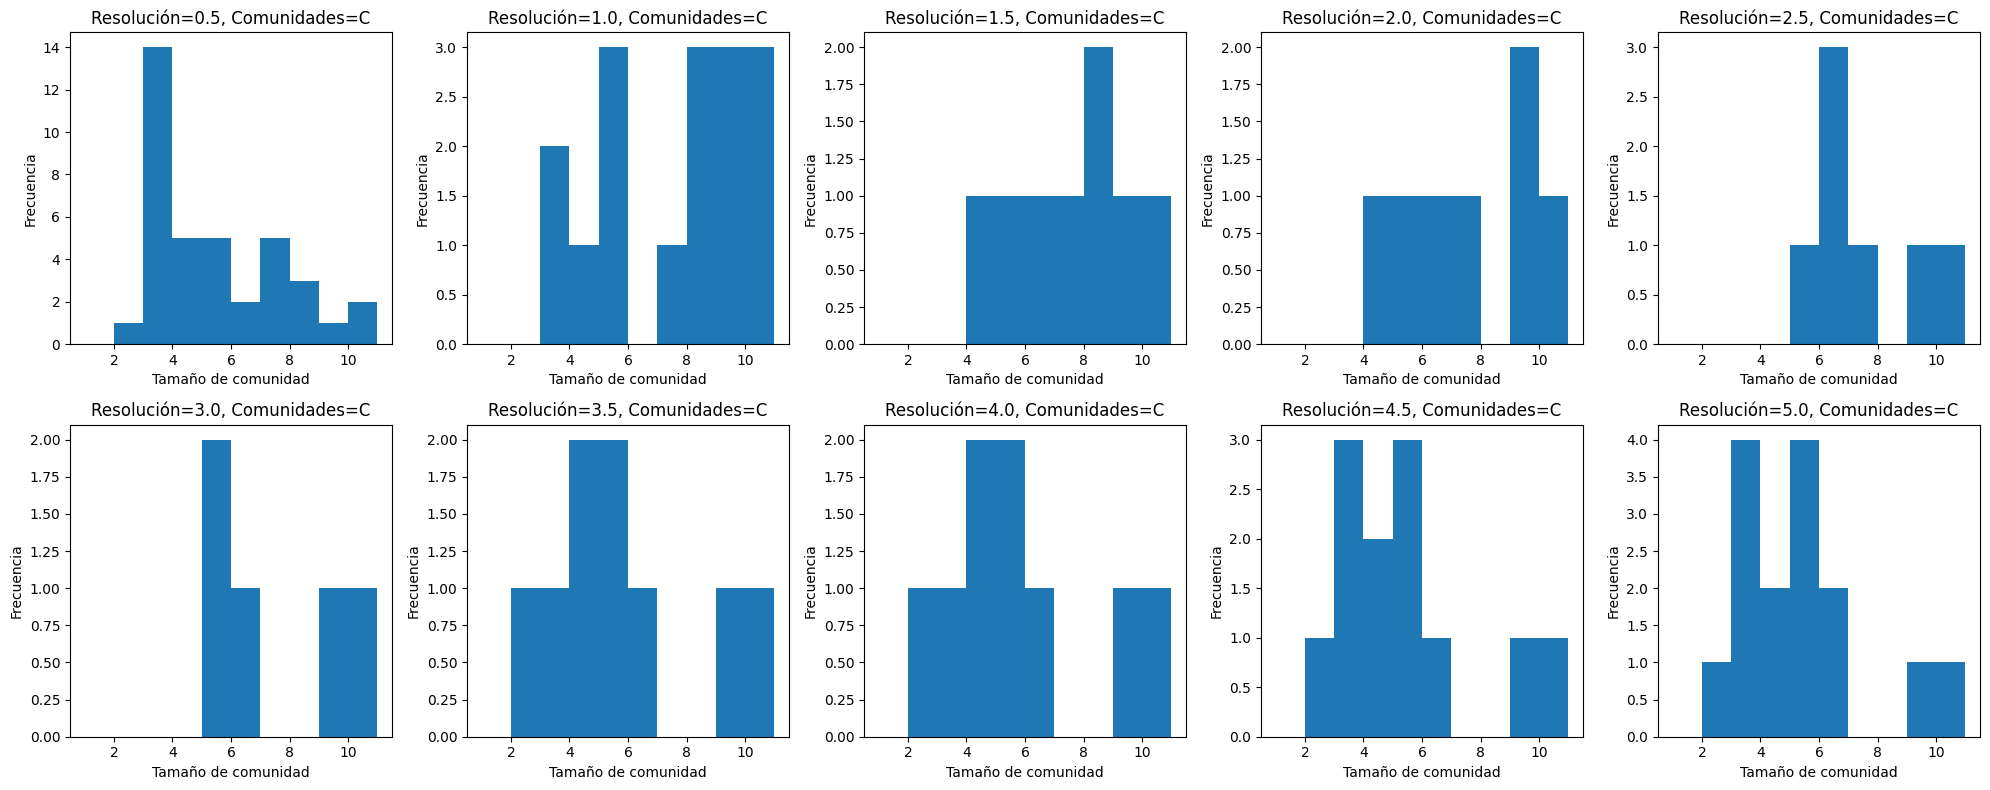

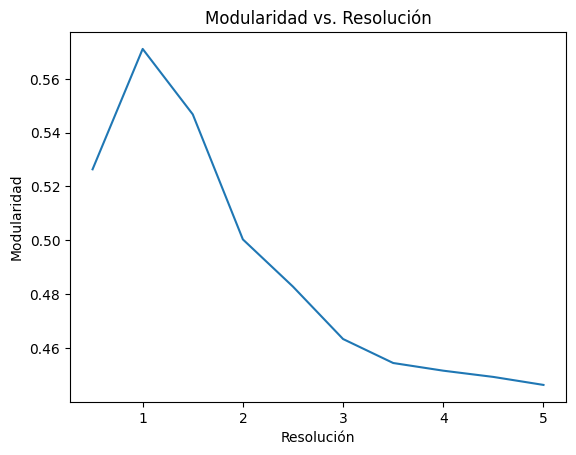

In [59]:
import matplotlib.pyplot as plt

# Definir una lista de valores de resolución para probar
resolutions = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
n_communities = []
comm_sizes = []

for r in resolutions:
    louvain_partition = subG_igraph.community_multilevel(weights=None, return_levels=False, resolution=r)
    n_communities.append(louvain_partition.summary()[0])
    comm_sizes.append(louvain_partition.sizes())

# Graficar distribución de tamaños de comunidades para cada valor de resolución
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axs = axs.flatten()
for i, r in enumerate(resolutions):
    axs[i].hist(comm_sizes[i], bins=range(1, 12))
    axs[i].set_title(f"Resolución={r:.1f}, Comunidades={n_communities[i]}")
    axs[i].set_xlabel("Tamaño de comunidad")
    axs[i].set_ylabel("Frecuencia")
plt.tight_layout()

# Graficar modularidad para cada valor de resolución
modularity = [subG_igraph.community_multilevel(weights=None, return_levels=False, resolution=r).modularity for r in resolutions]
plt.figure()
plt.plot(resolutions, modularity)
plt.title("Modularidad vs. Resolución")
plt.xlabel("Resolución")
plt.ylabel("Modularidad")
plt.show()

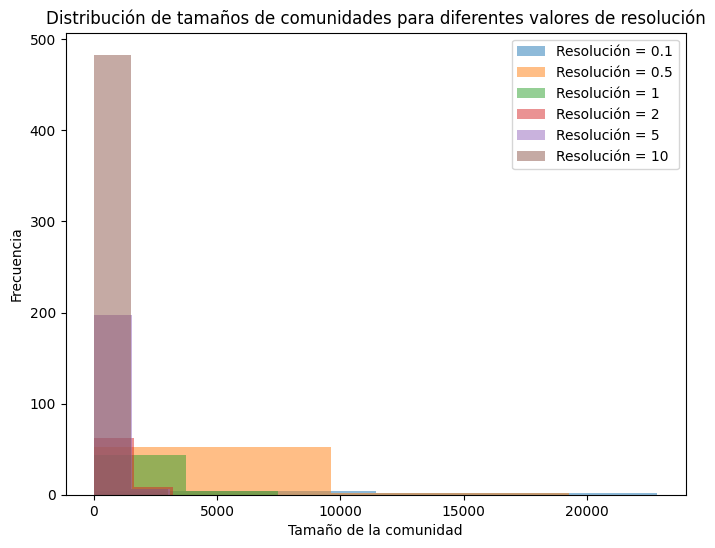

In [60]:
# Definir una lista de valores de resolución para probar
resolutions = [0.1, 0.5, 1, 2, 5, 10]

# Inicializar una lista para almacenar los tamaños de las comunidades
community_sizes = []

# Ejecutar el algoritmo de Louvain para cada valor de resolución
for r in resolutions:
    partition = subG_igraph.community_multilevel(weights=None, resolution=r)
    sizes = partition.sizes()
    community_sizes.append(sizes)

# Graficar la distribución de tamaños de las comunidades para cada valor de resolución
plt.figure(figsize=(8, 6))
plt.title("Distribución de tamaños de comunidades para diferentes valores de resolución")
plt.xlabel("Tamaño de la comunidad")
plt.ylabel("Frecuencia")
for i in range(len(resolutions)):
    plt.hist(community_sizes[i], alpha=0.5, label="Resolución = " + str(resolutions[i]), bins=2)
plt.legend(loc="best")
plt.show()

En este ejemplo, estamos probando valores de resolución desde 0.5 hasta 5 con un paso de 0.5, y para cada valor de resolución estamos calculando la cantidad de comunidades y la distribución de tamaños de las mismas. Luego, estamos graficando la distribución de tamaños de comunidades para cada valor de resolución, así como también la modularidad en función del valor de resolución.

Al ejecutar este código, se generará un conjunto de gráficos que muestran la distribución de tamaños de las comunidades para cada valor de resolución, así como también la modularidad en función del valor de resolución.

Observando los gráficos, se puede notar que para una resolución cercana a 2 se identifican dos grandes comunidades de tamaños similares, lo cual se puede corroborar visualizando el gráfico de distribución de tamaños de comunidades o la curva de modularidad. Sin embargo, es importante tener en cuenta que esto puede depender del grafo específico y que la elección de la resolución debe ser cuidadosa y ajustada para el problema que se está abordando.

# Aplicar el algoritmo de Label Propagation



In [61]:
communities = subG_igraph.community_label_propagation()

print(communities)

Clustering with 38998 elements and 165 clusters
[  0] 0, 1, 2, 3, 18, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
      45, 46, 47, 48, 49, 50, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79,
      80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 94, 95, 96, 97, 98, 99,
      107, 109, 110, 111, 113, 118, 122, 123, 124, 125, 126, 127, 128, 129,
      130, 131, 132, 133, 134, 135, 136, 137, 138, 148, 149, 150, 151, 152,
      153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
      167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
      181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
      195, 202, 204, 207, 212, 214, 215, 216, 217, 218, 219, 220, 221, 222,
      223, 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237,
      238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
      252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
      266, 267, 268, 269, 270, 272

In [62]:
# Obtener cantidad de comunidades
n_communities_label_propagation = communities.summary()

# Obtener distribución de tamaños de comunidades
comm_sizes_label_propagation = communities.sizes()

# Imprimir resultados
print(f"Cantidad de comunidades encontradas: {n_communities_label_propagation}")
print(f"Distribución de tamaños de comunidades: {comm_sizes_label_propagation}")

Cantidad de comunidades encontradas: Clustering with 38998 elements and 165 clusters
Distribución de tamaños de comunidades: [15471, 10313, 2928, 1746, 1746, 1506, 2880, 324, 5, 7, 19, 7, 5, 38, 12, 65, 10, 29, 45, 4, 13, 4, 9, 3, 4, 61, 5, 9, 2, 6, 7, 69, 32, 36, 7, 10, 27, 5, 6, 9, 3, 7, 30, 3, 32, 66, 5, 4, 2, 5, 20, 3, 4, 30, 4, 9, 13, 44, 3, 33, 2, 21, 9, 7, 4, 9, 25, 3, 8, 8, 24, 4, 3, 3, 25, 4, 5, 2, 5, 88, 6, 22, 3, 3, 7, 10, 4, 32, 9, 6, 9, 3, 14, 21, 4, 5, 3, 3, 5, 8, 4, 41, 3, 4, 3, 10, 4, 15, 9, 5, 9, 3, 9, 11, 3, 13, 29, 54, 21, 18, 7, 13, 6, 13, 7, 29, 3, 3, 37, 8, 11, 13, 3, 8, 5, 3, 5, 3, 15, 4, 3, 8, 11, 17, 10, 13, 43, 13, 6, 42, 15, 6, 3, 3, 3, 11, 30, 3, 5, 4, 5, 3, 26, 5, 6]


# Conclusiones

In [65]:
modularidad_louvain_partition = subG_igraph.modularity(louvain_partition)


modularidad_label_propagation = subG_igraph.modularity(communities)


print(f"modularidad_louvain_partition: {modularidad_louvain_partition}")
print(f"modularidad_label_propagation: {modularidad_label_propagation}")

modularidad_louvain_partition: 0.44611134038214206
modularidad_label_propagation: 0.5402008594485996


Modularidad: La modularidad es una medida común de la calidad de una partición de la red en comunidades. La modularidad mide la densidad de conexiones dentro de una comunidad en comparación con las conexiones entre comunidades. Un valor de modularidad cercano a 1 indica una partición muy buena, mientras que un valor cercano a 0 indica una partición pobre.